### Predicting Amount of Tip

In [1]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression, GeneralizedLinearRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from google.cloud import storage
import pandas as pd
import numpy as np

In [2]:
#Read 2019 cleaned trip data's files
sdf = spark.read.parquet("XXX/Cleaned_November_13/fhvhv_tripdata_2019-*.parquet_cleaned.parquet")

In [3]:
from pyspark.sql.functions import col

# Read the Parquet file
file_path = "XXX/Cleaned_November_13/fhvhv_tripdata_2019-*.parquet_cleaned.parquet"
sdf = spark.read.parquet(file_path)

In [4]:
sdf.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- wav_request_flag: string (nullable = true)



In [5]:
# String
string_sdf = ['hvfhs_license_num','dispatching_base_num', 'shared_request_flag', 'shared_match_flag', 'wav_request_flag', 'yearmonth', 'dayofweek']

#Integer
int_sdf = [ 'PULocationID', 'DOLocationID', 'year', 'month','airport_fee']

#Datetime
date_sdf = ['pickup_datetime', 'dropoff_datetime', 'request_datetime']

#Float/double
float_sdf = ['trip_miles','trip_time','base_passenger_fare','tolls','bcf', 'sales_tax', 'congestion_surcharge','tips','driver_pay', 'weekend'] #Note: Weekend only has binary values 1.0 or 0.0


In [6]:
# 1. Extract date and time features (Year, Month, Day, Day of Week, Quarter, Hour)
sdf = sdf.withColumn("year", year(col("pickup_datetime")))
sdf = sdf.withColumn("month", month(col("pickup_datetime")))   # Numeric month like 11
sdf = sdf.withColumn("yearmonth", date_format(col("pickup_datetime"), "yyyy-MM"))   # Like 2023-01   2023-02 etc.
sdf = sdf.withColumn("dayofweek", date_format(col("pickup_datetime"), "EEEE"))         # 'Monday' 'Tuesday' etc.
sdf = sdf.withColumn("weekend", when(sdf.dayofweek == 'Saturday',1.0).when(sdf.dayofweek == 'Sunday', 1.0).otherwise(0))

# Check columns to see if we got good values
sdf.select(["year", "month", "yearmonth", "dayofweek", "weekend"]).show()

+----+-----+---------+---------+-------+
|year|month|yearmonth|dayofweek|weekend|
+----+-----+---------+---------+-------+
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
|2019|    2|  2019-02|   Friday|    0.0|
+----+-----+---------+---------+-------+
only showing top

In [7]:
sdf.printSchema()

root
 |-- hvfhs_license_num: string (nullable = true)
 |-- dispatching_base_num: string (nullable = true)
 |-- request_datetime: timestamp_ntz (nullable = true)
 |-- pickup_datetime: timestamp_ntz (nullable = true)
 |-- dropoff_datetime: timestamp_ntz (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- trip_miles: double (nullable = true)
 |-- trip_time: long (nullable = true)
 |-- base_passenger_fare: double (nullable = true)
 |-- tolls: double (nullable = true)
 |-- bcf: double (nullable = true)
 |-- sales_tax: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- tips: double (nullable = true)
 |-- driver_pay: double (nullable = true)
 |-- shared_request_flag: string (nullable = true)
 |-- shared_match_flag: string (nullable = true)
 |-- wav_request_flag: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- yearmonth: string (nullable = true)
 |-- da

### Features code

In [8]:
# Predict the amount of tip!

# Split the data into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)

# Create an indexer for the three string based columns. 
indexer = StringIndexer(inputCols=['dayofweek'], outputCols=['dayofweek_index'], handleInvalid="keep")

# Create an encoder for the three indexes and the age integer column.
encoder = OneHotEncoder(inputCols=['dayofweek_index', 'PULocationID', 'DOLocationID'],
                        outputCols=['dayofweekVector', 'PULocationIDVector', 'DOLocationIDVector' ], dropLast=True, handleInvalid="keep")

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['dayofweekVector', 'PULocationIDVector', 'DOLocationIDVector','trip_miles','trip_time','base_passenger_fare','driver_pay'], outputCol="features")

# Create a Linear Regression Estimator
linear_reg = LinearRegression(labelCol='tips')

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='tips')

# Create the pipeline   Indexer is stage 0 and Linear Regression (linear_reg)  is stage 3
regression_pipe = Pipeline(stages=[indexer, encoder, assembler, linear_reg])

In [12]:
#Libraries to import
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import io
from google.cloud import storage

<Figure size 1000x600 with 0 Axes>

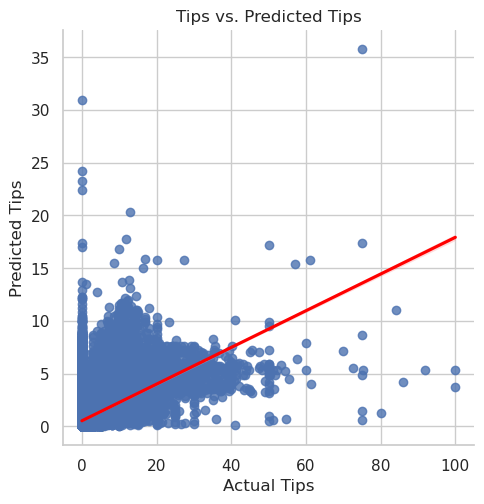

In [21]:
# Sample 10% of the data
sampled_df = test_predictions.select("tips", "prediction").sample(False, 0.1, seed=42).toPandas()

# Scatter plot of Actual vs Predicted Tips
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lmplot(x='tips', y='prediction', data=sampled_df, line_kws={'color': 'red'})
plt.title('Tips vs. Predicted Tips')
plt.xlabel('Actual Tips')
plt.ylabel('Predicted Tips')

plt.show()

### Linear Regression

In [16]:
# Predict the amount of tip!

# Split the data into training and test sets
trainingData, testData = sdf.randomSplit([0.70, 0.3], seed=42)

# Create an indexer for the three string based columns. 
indexer = StringIndexer(inputCols=['dayofweek'], outputCols=['dayofweek_index'], handleInvalid="keep")

# Create an encoder for the three indexes and the age integer column.
encoder = OneHotEncoder(inputCols=['dayofweek_index', 'PULocationID', 'DOLocationID'],
                        outputCols=['dayofweekVector', 'PULocationIDVector', 'DOLocationIDVector' ], dropLast=True, handleInvalid="keep")

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['dayofweekVector', 'PULocationIDVector', 'DOLocationIDVector','trip_miles','trip_time','base_passenger_fare','driver_pay'], outputCol="features")

# Create a Linear Regression Estimator
linear_reg = LinearRegression(labelCol='tips')

# Create a regression evaluator (to get RMSE, R2, RME, etc.)
evaluator = RegressionEvaluator(labelCol='tips')

# Create the pipeline   Indexer is stage 0 and Linear Regression (linear_reg)  is stage 3
regression_pipe = Pipeline(stages=[indexer, encoder, assembler, linear_reg])

# Create a grid to hold hyperparameters 
grid = ParamGridBuilder()

# Build the parameter grid
grid = grid.build()

# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=regression_pipe, 
                    estimatorParamMaps=grid, 
                    evaluator=evaluator, 
                    numFolds=3)

# Train the models
all_models  = cv.fit(trainingData)

# Show the average performance over the three folds
print(f"Average metric {all_models.avgMetrics}")

# Get the best model from all of the models trained
bestModel = all_models.bestModel

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

# Show the predicted tip
test_results.select('dayofweek','PULocationID','DOLocationID','trip_miles','trip_time','base_passenger_fare','driver_pay','prediction').show(truncate=False)

# Calculate RMSE and R2
rmse = evaluator.evaluate(test_results, {evaluator.metricName:'rmse'})
r2 =evaluator.evaluate(test_results,{evaluator.metricName:'r2'})
print(f"RMSE: {rmse}  R-squared:{r2}")

24/12/05 03:26:23 WARN Instrumentation: [ad180482] regParam is zero, which might cause numerical instability and overfitting.
24/12/05 03:26:50 WARN Instrumentation: [ad180482] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/05 03:30:12 WARN Instrumentation: [7db5192b] regParam is zero, which might cause numerical instability and overfitting.
24/12/05 03:30:36 WARN Instrumentation: [7db5192b] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/05 03:33:53 WARN Instrumentation: [3edc541a] regParam is zero, which might cause numerical instability and overfitting.
24/12/05 03:34:17 WARN Instrumentation: [3edc541a] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
24/12/05 03:37:47 WARN Instrumentation: [12bd134c] regParam is zero, which might cause numerical instability and overfitting.
24/12/05 03:39:13 WARN Instrumentation: [12bd134c] Cholesky solv

Average metric [2.090681885223297]


+---------+------------+------------+----------+---------+-------------------+----------+---------------------+
|dayofweek|PULocationID|DOLocationID|trip_miles|trip_time|base_passenger_fare|driver_pay|prediction           |
+---------+------------+------------+----------+---------+-------------------+----------+---------------------+
|Friday   |211         |112         |6.5       |1887     |49.95              |44.48     |2.9392739400794143   |
|Friday   |186         |232         |4.09      |1173     |18.41              |18.59     |1.0181939267558981   |
|Friday   |186         |262         |3.81      |1341     |19.11              |25.1      |1.698478928268529    |
|Friday   |186         |48          |2.16      |946      |12.32              |15.3      |1.1211359888854953   |
|Friday   |132         |229         |18.02     |1915     |39.76              |33.23     |1.3955378822242046   |
|Friday   |78          |136         |1.69      |640      |9.69               |7.6       |-0.070233931339

RMSE: 2.0895336513487552  R-squared:0.17273966681038688


### Data Visualization for Linear Regression

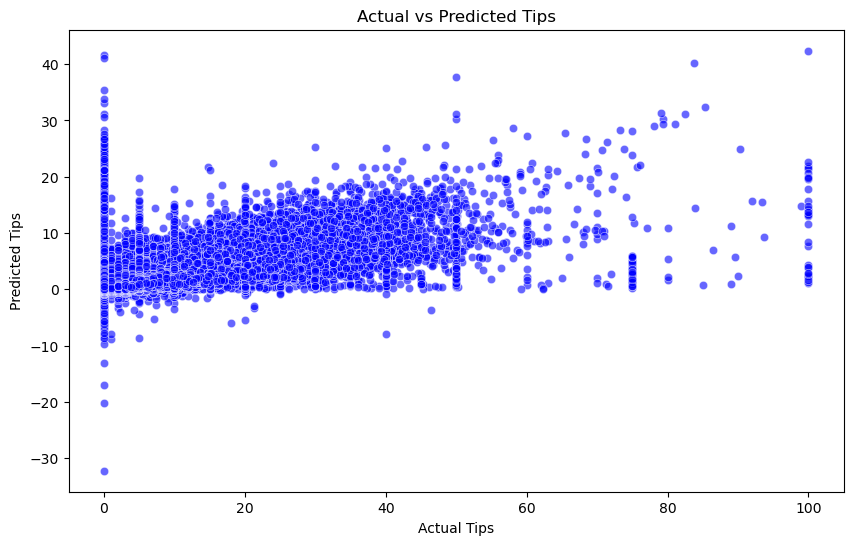

In [19]:
#Scatter Plot Tips vs Prediction
df = test_results.select("tips", "prediction").sample(False, 0.1).toPandas()

# Plotting the sample data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='tips', y='prediction', data=df, color='blue', alpha=0.6)
plt.title('Actual vs Predicted Tips')
plt.xlabel('Actual Tips')
plt.ylabel('Predicted Tips')
plt.show()

In [21]:
# Extract the linear regression model from the best model in the pipeline
linear_reg_model = bestModel.stages[-1]  # LinearRegression model is the last stage

# Get the coefficients and the intercept
coefficients = linear_reg_model.coefficients
intercept = linear_reg_model.intercept

# Get the feature names used in the model
feature_names = ['dayofweekVector', 'PULocationIDVector', 'DOLocationIDVector', 
                 'trip_miles', 'trip_time', 'base_passenger_fare', 'driver_pay']

# Combine the feature names with their corresponding coefficients
feature_importance = list(zip(feature_names, coefficients))

# Convert to a DataFrame for better readability and sorting
import pandas as pd
feature_importance_df = pd.DataFrame(feature_importance, columns=['Feature', 'Coefficient'])

# Sort by the absolute value of coefficients to find the most important features
feature_importance_df['Absolute Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Absolute Coefficient', ascending=False)

# Display the sorted features and their coefficients
print("Feature Importance based on Coefficients:")
print(feature_importance_df)

# Show the intercept as well
print(f"Intercept: {intercept}")


Feature Importance based on Coefficients:
               Feature  Coefficient  Absolute Coefficient
2   DOLocationIDVector    -0.045694              0.045694
5  base_passenger_fare     0.026731              0.026731
4            trip_time     0.025859              0.025859
3           trip_miles     0.007982              0.007982
1   PULocationIDVector    -0.006319              0.006319
0      dayofweekVector    -0.004280              0.004280
6           driver_pay     0.002160              0.002160
Intercept: 0.012965718603642422


In [7]:
df = test_results.select("dayofweek","tips", "prediction").sample(False, 0.1).toPandas()

In [9]:
df.tail()

,dayofweek,tips,prediction
6208808,Monday,2.00,0.242160
6208809,Monday,0.00,0.222240
6208810,Monday,0.00,0.000451
6208811,Monday,2.55,0.440868
6208812,Monday,0.00,0.796399


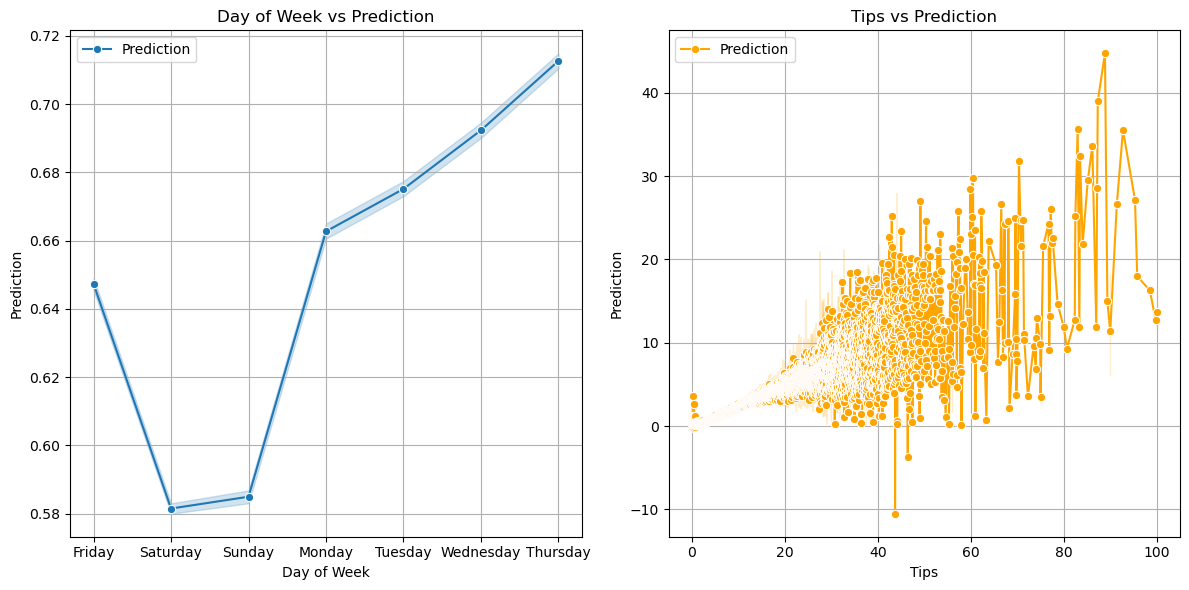

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sample the data into a Pandas DataFrame
df = test_results.select("dayofweek", "tips", "prediction").sample(False, 0.1).toPandas()

# Plot 1: Line plot of 'dayofweek' vs 'prediction'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot (1 row, 2 columns, first plot)
sns.lineplot(x="dayofweek", y="prediction", data=df, marker="o", label="Prediction")
plt.title("Day of Week vs Prediction")
plt.xlabel("Day of Week")
plt.ylabel("Prediction")
plt.grid(True)

# Plot 2: Line plot of 'tips' vs 'prediction'
plt.subplot(1, 2, 2)  # Second plot
sns.lineplot(x="tips", y="prediction", data=df, marker="o", color="orange", label="Prediction")
plt.title("Tips vs Prediction")
plt.xlabel("Tips")
plt.ylabel("Prediction")
plt.grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


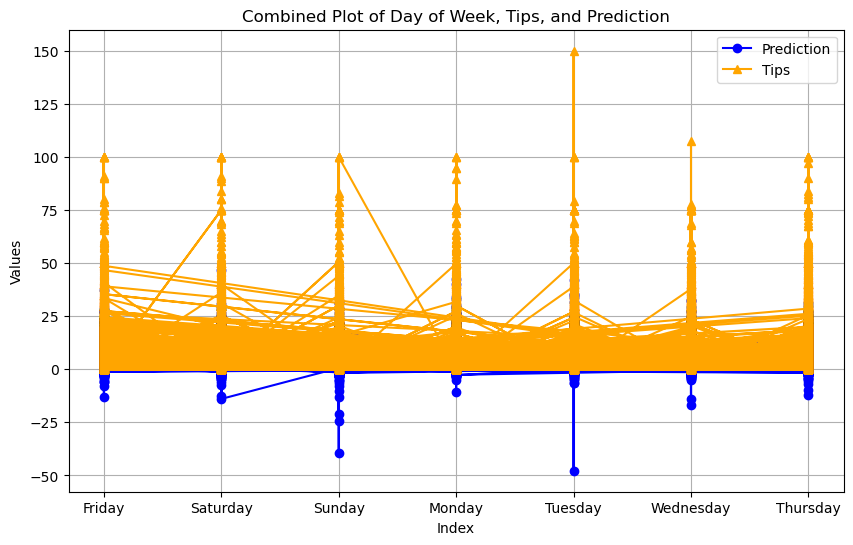

Plot successfully saved to GCS: Trusted/Combinedplot_Dayofweek_Tips_Prediction.png


<Figure size 640x480 with 0 Axes>

In [19]:
import io
from google.cloud import storage
import matplotlib.pyplot as plt

# Convert the Spark DataFrame to Pandas
df = test_results.select("dayofweek", "tips", "prediction").sample(False, 0.1).toPandas()

# Plot all three columns on the same graph
plt.figure(figsize=(10, 6))

# Line plot for each column
plt.plot(df["dayofweek"], df["prediction"], label="Prediction", marker="o", color="blue")
plt.plot(df["dayofweek"], df["tips"], label="Tips", marker="^", color="orange")

# Add title, labels, and legend
plt.title("Combined Plot of Day of Week, Tips, and Prediction")
plt.xlabel("Index")
plt.ylabel("Values")
plt.legend()
plt.grid(True)

plt.show()

# Save the plot to Google Cloud Storage
def save_plot_to_gcs(plt, filename, bucket_name, blob_path):
    # Create a buffer
    img_data = io.BytesIO()
    # Save the plot to the buffer
    plt.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start
    img_data.seek(0)
    
    # Upload to Google Cloud Storage
    try:
        # Create a storage client
        storage_client = storage.Client()
        # Get the bucket by name (no folder in the bucket name)
        bucket = storage_client.get_bucket(bucket_name)
        # Create a blob for the file path inside the bucket
        blob = bucket.blob(blob_path)  # Use blob_path for the directory and filename
        # Upload the image
        blob.upload_from_file(img_data)
        
        # Check if the file was successfully uploaded
        if blob.exists():
            print(f"Plot successfully saved to GCS: {blob_path}")
        else:
            print(f"Failed to save plot to GCS: {blob_path}")
    except Exception as e:
        print(f"Error uploading plot to GCS: {e}")

# Call the function to save the plot
save_plot_to_gcs(plt, "Combinedplot_Dayofweek_Tips_Prediction.png", "XXX", "Trusted/Combinedplot_Dayofweek_Tips_Prediction.png")


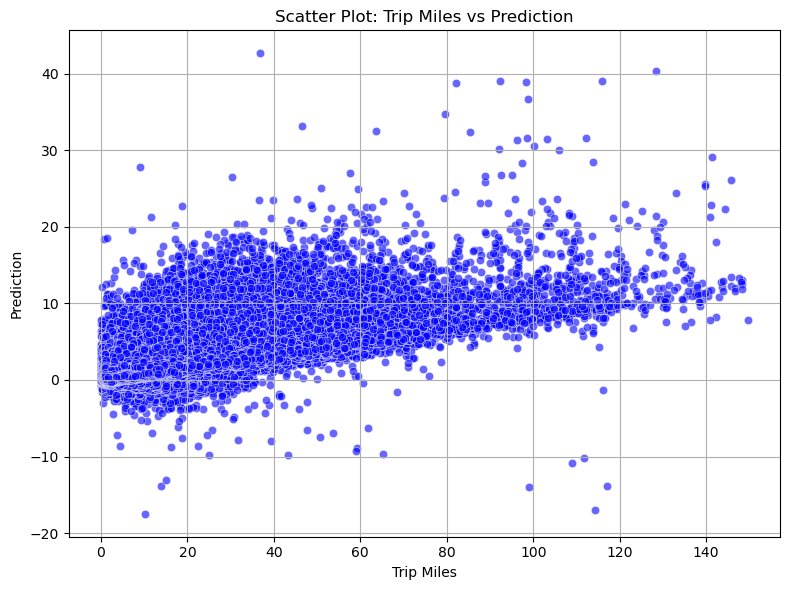

Plot successfully saved to GCS: Trusted/scatter_trip_miles_vs_prediction.png


<Figure size 640x480 with 0 Axes>

In [20]:
import io
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the Spark DataFrame to Pandas
df = test_results.select("trip_miles", "prediction").sample(False, 0.1).toPandas()

# Create a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x="trip_miles", y="prediction", data=df, color="blue", alpha=0.6)

# Add title and labels
plt.title("Scatter Plot: Trip Miles vs Prediction")
plt.xlabel("Trip Miles")
plt.ylabel("Prediction")
plt.grid(True)

plt.show()

# Save the plot to Google Cloud Storage
def save_plot_to_gcs(plt, filename, bucket_name, blob_path):
    # Create a buffer
    img_data = io.BytesIO()
    # Save the plot to the buffer
    plt.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start
    img_data.seek(0)
    
    # Upload to Google Cloud Storage
    try:
        # Create a storage client
        storage_client = storage.Client()
        # Get the bucket by name (no folder in the bucket name)
        bucket = storage_client.get_bucket(bucket_name)
        # Create a blob for the file path inside the bucket
        blob = bucket.blob(blob_path)  # Use blob_path for the directory and filename
        # Upload the image
        blob.upload_from_file(img_data)
        
        # Check if the file was successfully uploaded
        if blob.exists():
            print(f"Plot successfully saved to GCS: {blob_path}")
        else:
            print(f"Failed to save plot to GCS: {blob_path}")
    except Exception as e:
        print(f"Error uploading plot to GCS: {e}")

# Call the function to save the scatter plot
save_plot_to_gcs(plt, "scatter_trip_miles_vs_prediction.png", "XXX", "Trusted/scatter_trip_miles_vs_prediction.png")


/tmp/ipykernel_10443/4188721396.py:11: FutureWarning:                           

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="dayofweek", data=df, palette="viridis")


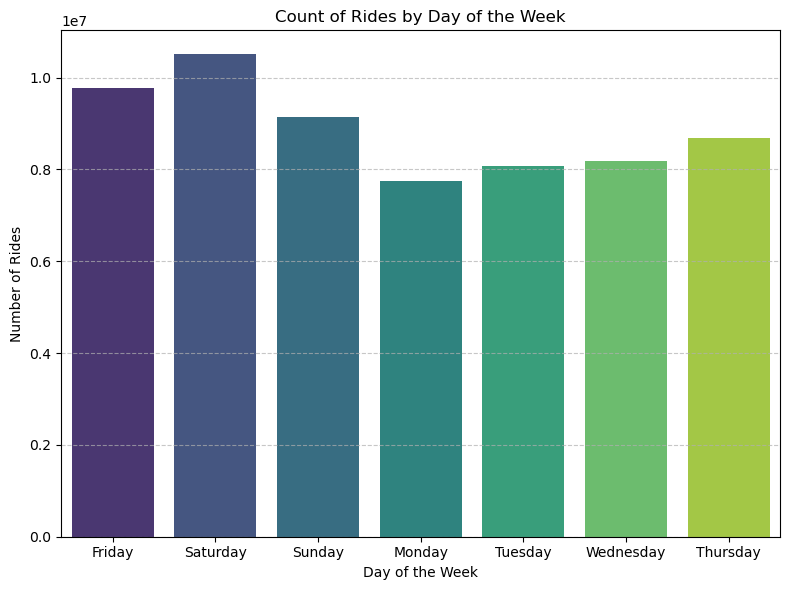

Plot successfully saved to GCS: Trusted/bar_count_of_rides_by_day_of_week.png


<Figure size 640x480 with 0 Axes>

In [21]:
import io
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas
df = test_results.select("dayofweek").toPandas()

# Bar plot to count rides for each day of the week
plt.figure(figsize=(8, 6))
sns.countplot(x="dayofweek", data=df, palette="viridis")

# Add title and labels
plt.title("Count of Rides by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Rides")
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot to Google Cloud Storage
def save_plot_to_gcs(plt, filename, bucket_name, blob_path):
    # Create a buffer
    img_data = io.BytesIO()
    # Save the plot to the buffer
    plt.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start
    img_data.seek(0)
    
    # Upload to Google Cloud Storage
    try:
        # Create a storage client
        storage_client = storage.Client()
        # Get the bucket by name (no folder in the bucket name)
        bucket = storage_client.get_bucket(bucket_name)
        # Create a blob for the file path inside the bucket
        blob = bucket.blob(blob_path)  # Use blob_path for the directory and filename
        # Upload the image
        blob.upload_from_file(img_data)
        
        # Check if the file was successfully uploaded
        if blob.exists():
            print(f"Plot successfully saved to GCS: {blob_path}")
        else:
            print(f"Failed to save plot to GCS: {blob_path}")
    except Exception as e:
        print(f"Error uploading plot to GCS: {e}")

# Save the bar plot
save_plot_to_gcs(plt, "bar_count_of_rides_by_day_of_week.png", "XXX", "Trusted/bar_count_of_rides_by_day_of_week.png")


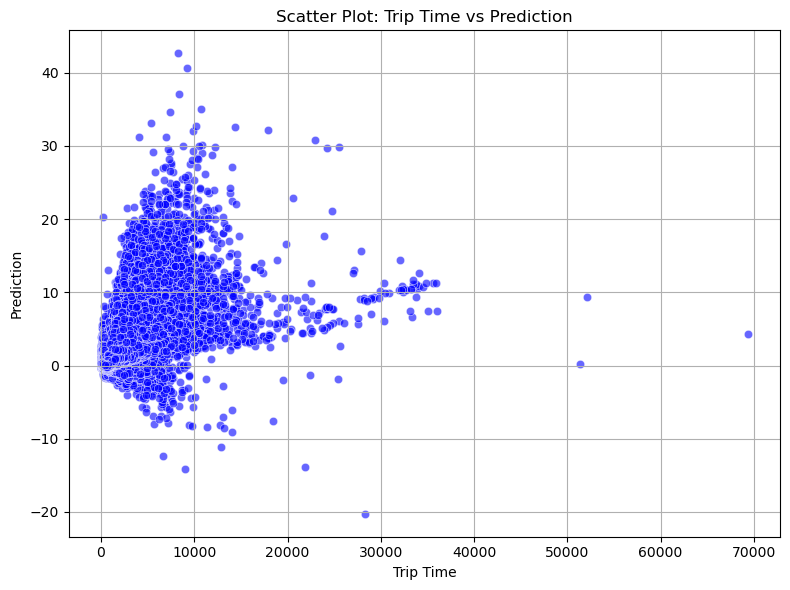

Plot successfully saved to GCS: Trusted/scatter_trip_time_vs_prediction.png


<Figure size 640x480 with 0 Axes>

In [22]:
import io
from google.cloud import storage
import matplotlib.pyplot as plt
import seaborn as sns

# Convert Spark DataFrame to Pandas
df = test_results.select("trip_time", "prediction").sample(False, 0.1).toPandas()

# Scatter plot for trip_time vs prediction
plt.figure(figsize=(8, 6))
sns.scatterplot(x="trip_time", y="prediction", data=df, color="blue", alpha=0.6)

# Add title and labels
plt.title("Scatter Plot: Trip Time vs Prediction")
plt.xlabel("Trip Time")
plt.ylabel("Prediction")
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Save the plot to Google Cloud Storage
def save_plot_to_gcs(plt, filename, bucket_name, blob_path):
    # Create a buffer
    img_data = io.BytesIO()
    # Save the plot to the buffer
    plt.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start
    img_data.seek(0)
    
    # Upload to Google Cloud Storage
    try:
        # Create a storage client
        storage_client = storage.Client()
        # Get the bucket by name (no folder in the bucket name)
        bucket = storage_client.get_bucket(bucket_name)
        # Create a blob for the file path inside the bucket
        blob = bucket.blob(blob_path)  # Use blob_path for the directory and filename
        # Upload the image
        blob.upload_from_file(img_data)
        
        # Check if the file was successfully uploaded
        if blob.exists():
            print(f"Plot successfully saved to GCS: {blob_path}")
        else:
            print(f"Failed to save plot to GCS: {blob_path}")
    except Exception as e:
        print(f"Error uploading plot to GCS: {e}")

# Save the scatter plot
save_plot_to_gcs(plt, "scatter_trip_time_vs_prediction.png", "XXX", "Trusted/scatter_trip_time_vs_prediction.png")


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the test results to a Pandas DataFrame for easier plotting
test_results_df = test_results.select('dayofweek', 'PULocationID', 'DOLocationID', 'trip_miles', 
                                      'trip_time', 'base_passenger_fare', 'driver_pay', 'prediction').toPandas()

# Create a list of features to plot
features = ['dayofweek', 'PULocationID', 'DOLocationID', 'trip_miles', 'trip_time', 'base_passenger_fare', 'driver_pay']

# Set up the plotting grid
plt.figure(figsize=(15, 10))

# Plot each feature against the predicted tips
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.scatterplot(x=test_results_df[feature], y=test_results_df['prediction'], color='blue', alpha=0.6)
    plt.title(f'{feature} vs Predicted Tips')
    plt.xlabel(feature)
    plt.ylabel('Predicted Tips')

plt.tight_layout()  # Adjust the spacing between plots
plt.show()


In [ ]:
###GENERAL CODE TO SAVE PLOT TO TRUSTED
import io
from google.cloud import storage
import matplotlib.pyplot as plt

# Save the plot to Google Cloud Storage
def save_plot_to_gcs(plt, filename, bucket_name):
    # Create a buffer
    img_data = io.BytesIO()
    # Save the plot to the buffer
    plt.savefig(img_data, format='png', bbox_inches='tight')
    # Rewind the pointer to the start
    img_data.seek(0)
    
    # Upload to Google Cloud Storage
    try:
        storage_client = storage.Client()
        bucket = storage_client.get_bucket(bucket_name)
        blob = bucket.blob(filename)
        blob.upload_from_file(img_data)
        
        # Check if the file was successfully uploaded
        if blob.exists():
            print(f"Plot successfully saved to GCS: {filename}")
        else:
            print(f"Failed to save plot to GCS: {filename}")
    except Exception as e:
        print(f"Error uploading plot to GCS: {e}")

# Save the scatter plot
save_plot_to_gcs(plt, "scatter_actual_vs_predicted.png", "XXX/Trusted")
